# Training and Deploying a Text Classification model using Amazon SageMaker Pipelines

<a id ='background'></a>

## Background

[Amazon SageMaker Pipelines](https://aws.amazon.com/sagemaker/pipelines/) makes it easy for data scientists and engineers to build, automate, and scale end-to-end machine learning workflows. Machine learning workflows are complex, requiring iteration and experimentation across each step of the machine learning process, such as exploring and preparing data, experimenting with different algorithms, training and turning models, and deploying models to production. Developing and managing these workflows can take weeks or months of coding and manually managing workflow dependencies can become complex. With Amazon SageMaker Pipelines, data science teams have an easy-to-use continuous integration and continuous delivery (CI/CD) service that simplifies the development and management of machine learning workflows at scale.

In this notebook, we use SageMaker Pipelines to train and deploy a text classification model to predict e-commerce product ratings based on customers’ product reviews. We’ll use BlazingText, one of the SageMaker [built-in algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algorithms-choose.html#built-in-algorithms-benefits), to minimize the amount of effort required to train and deploy the model. [BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html) provides highly optimized implementations of Word2vec and text classification algorithms.

To train the model, we’ll use a sample of data containing e-commerce reviews and associated product ratings. This data has been generated by customers that have rated products on a scale between 1 (worst) and 5 (best), and have left a short review. Our pipeline will start with processing the data for model training and will proceed with model training, evaluation, registry and deployment. The [Women’s E-Commerce Clothing Reviews](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/) dataset has been made available under a [Creative Commons license](https://creativecommons.org/publicdomain/zero/1.0/). A copy of the dataset has been saved in a sample data Amazon S3 bucket. In the first section of the notebook, we’ll walk through how to download the data and get started with building the ML workflow as a SageMaker pipeline.



## Contents

- [Project setup](#setup)
    - [Set up SageMaker environment](#environment)
    - [Obtain training data](#obtain-data)
- [Step 0: Prepare pipeline parameters](#pipeline-parameters)
- [Step 1: Create dataset and train/test split](#dataset-train-test)
- [Step 2: Train text classification model using BlazingText](#train-model)
- [Step 3: Model creation](#create-model)
- [Step 4: Deploy model](#deploy-model)
- [Step 5: Register model](#register-model)
- [Step 6: Create pipeline](#create-pipeline)
- [Use deployed model to return predictions](#return-predictions)




<a id ='setup'></a>

## Project setup

In this section, we'll install some necessary packages, set parameters that we can use in the pipeline and download the training data.

<a id ='environment'></a>

### Set up SageMaker environment



In [ ]:
#install necessary packages
import boto3
import pandas as pd
import numpy as np
import sagemaker
print(f'SageMaker version: {sagemaker.__version__}')

In [ ]:
#import necessary execution role so that you can read from S3 buckets
role = sagemaker.get_execution_role()

#source default session parameters (region, default S3 bucket etc)
region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()
s3_client = boto3.client('s3', region_name=region)
sagemaker_client = boto3.client("sagemaker-runtime")
default_bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker-pipelines-nlp-demo'

<a id ='obtain-data'></a>

### Obtain training data

To get started, we'll download the training data from a public S3 bucket and then upload the data to our own S3 bucket.

In [ ]:
!mkdir -p data
!wget https://sagemaker-sample-files.s3.amazonaws.com/datasets/tabular/womens_clothing_ecommerce/Womens_Clothing_E-Commerce_Reviews.csv -O 'data/Womens Clothing E-Commerce Reviews.csv'


In [4]:
df = pd.read_csv('data/Womens Clothing E-Commerce Reviews.csv',  index_col=0)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


A quick look at the distribution of product ratings shows us that the dataset is imbalanced; there are more observations with good product ratings than poor product ratings. This inbalance in the training data set may lead to a tendency to favor the majority classes (high product ratings) and overall poor model accuracy. During the data processing step, we'll mitigate the impact of the imbalanced dataset by:

* Grouping ratings of 1 & 2 in to a larger 'negative review' category
* Oversampling the 'negative review+' minority class
* Ignoring neutral reviews (ratings of 3 & 4) to remove reviews that may be difficult to distinguish from positive and negative reviews. While this means that we will be unable to classify reviews as neutral, this may enable the model to better flag positive and negative reviews and therefor identify customers that require additional customer service attention or who are particularly likely to purchase additional products.


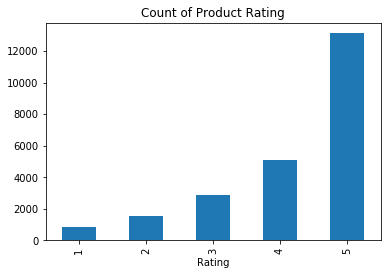

In [5]:
plot = df.groupby('Rating')['Rating'].count().plot(kind='bar', title = 'Count of Product Rating')

In [ ]:
#upload the data to your default S3 bucket or another S3 bucket of your choosing
local_path = "data/Womens Clothing E-Commerce Reviews.csv"

base_uri = f"s3://{default_bucket}/{prefix}/data"
input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path,
    desired_s3_uri=base_uri,
)
print(input_data_uri)

<a id ='pipeline-parameters'></a>

## Step 0: Define parameters to parametrize pipeline execution

Using SageMaker Pipelines, we can define the steps to be included in a pipeline but then use parameters to modify that pipeline when we go to execute the pipeline, without having to modify the pipeline definition. We'll provide some default parameter values that can be overridden on pipeline execution.


In [ ]:
from sagemaker.workflow.parameters import (ParameterInteger, ParameterString)

#specify location of input data
input_data = ParameterString(
    name="InputData",
    default_value=input_data_uri,
)

#specify default number of instances for processing step
processing_instance_count = ParameterInteger(
    name="ProcessingInstanceCount",
    default_value=1
)

#specify default instance type for processing step
processing_instance_type = ParameterString(
    name="ProcessingInstanceType",
    default_value="ml.m4.xlarge"
)

#specify default instance type for training step
train_instance_type = ParameterString(
    name="TrainingInstanceType",
    default_value="ml.m4.xlarge",
)

#specify default model approval mode
model_approval_status = ParameterString(
    name="ModelApprovalStatus",
    default_value="Approved"
)



<a id='dataset-train-test'></a>

### Step 1: Create Dataset and Train/Test Split

In this step, an SKLearn processor is used to prepare the data for model training. This data processing includes converting the review text to lowercase, removing carriage returns and line breaks and removing punctuation. We also group categories and conduct oversampling to reduce training dataset imbalance. Additionally, we process the reviews so that the training input data is in the format expected by the BlazingText algorithm (see more information here: https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html#bt-inputoutput) and we split the data in to training, testing and validation datasets.


In [ ]:
!mkdir -p code

In [ ]:
%%writefile code/preprocessing.py

import numpy as np
import pandas as pd
import string
from sklearn.utils import resample

base_dir = "/opt/ml/processing"

df = pd.read_csv( f"{base_dir}/input/Womens Clothing E-Commerce Reviews.csv")
df = df[df['Review Text'].notna()] # drop rows where Review text is missing

def process_review(text):
    punctuation = string.punctuation
    review = text.lower()
    review = review.replace("\r\n", " ").replace("\n\n", " ")
    translator = str.maketrans("","", punctuation)
    review  = review.translate(translator)
    return review
    
# create columns for concat reviews and new labels
df['Complete_Review'] = df['Title'] + ' ' + df['Review Text']
df = df[df['Complete_Review'].notna()] # drop rows where review text is missing
df['Label'] = df['Rating'].map({1:'negative',2:'negative',3:'none',4:'none',5:'positive'})
df = df.loc[df['Label'].isin(['negative','positive'])] # only use positive and negative reviews
df['Review'] = df['Complete_Review'].astype(str).apply(process_review)
df['Processed'] = '__label__' + df['Label'].astype(str) + ' ' + df['Review']    

# create train:test split
train, validation, test = np.split(df, [int(0.7 * len(df)), int(0.85 * len(df))])

# deal with unbalanced classes
# only include resampling for training set so no data leakeage for validation sets
positive = train.loc[train['Label']=='positive']
negative = train.loc[train['Label']=='negative']

# oversample the minority classes
negative_oversample = resample(negative, replace=True, n_samples=len(positive))

# remake training set using balanced class camples
train = pd.concat([positive,negative_oversample])

# create Series datasets for BlazingText format
train = train['Processed']
validation = validation['Processed']
test = test['Processed']

# save datasets
pd.DataFrame(train).to_csv(f"{base_dir}/train/train.csv", header=False, index=False)
pd.DataFrame(validation).to_csv(f"{base_dir}/validation/validation.csv", header=False, index=False)
pd.DataFrame(test).to_csv(f"{base_dir}/test/test.csv", header=False, index=False)    

print(f"Number of reviews in the training dataset: {train.shape[0]}")
print(f"Number of reviews in the validation set: {validation.shape[0]}")

In [ ]:
from sagemaker.sklearn.processing import SKLearnProcessor

framework_version = "0.23-1"

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    base_job_name="sklearn-nlp-process",
    role=role,
)

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

s3_client.upload_file(Filename='./code/preprocessing.py', Bucket=default_bucket, Key=f'{prefix}/code/preprocessing.py')
preprocess_script_uri = f's3://{default_bucket}/{prefix}/code/preprocessing.py'

process_step = ProcessingStep(
    name="BTDemoProcessStep",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
    ],
    code=preprocess_script_uri,
)

<a id='train-model'></a>

### Step 2: Train text classification model using BlazingText

In [ ]:
# set up estimator:

from sagemaker.estimator import Estimator

bt_estimator = Estimator(
    role=role,
    instance_type=train_instance_type,
    instance_count=1,
    image_uri=sagemaker.image_uris.retrieve("blazingtext", region),
    output_path=f's3://{default_bucket}/{prefix}/training_jobs',
    base_job_name='bt-model-estimator',
    input_mode = 'File'
) 

#for more info on hyperparameters, see: https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html
bt_estimator.set_hyperparameters(mode="supervised",
                                 epochs=25,
                                 learning_rate=0.02,
                                 min_count=2,
                                 early_stopping=True,
                                 patience=4,
                                 min_epochs=10,
                                 word_ngrams=3
                                )

In [ ]:
# set up model training step 
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep

train_step = TrainingStep(
    name='BTDemoTrainStep',
    estimator=bt_estimator,
    inputs={
        'train': sagemaker.inputs.TrainingInput(
            s3_data=process_step.properties.ProcessingOutputConfig.Outputs['train'].S3Output.S3Uri,
            content_type="text/csv"
        ),
        'validation': sagemaker.inputs.TrainingInput(
            s3_data=process_step.properties.ProcessingOutputConfig.Outputs['test'].S3Output.S3Uri,
            content_type="text/csv"
        )
    }
)

<a id='create-model'></a>

### Step 3: Model creation

In [ ]:
from sagemaker.workflow.steps import CreateModelStep

model = sagemaker.model.Model(
    name='nlp-blaztext-model',
    image_uri=train_step.properties.AlgorithmSpecification.TrainingImage,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sagemaker_session,
    role=role
)

inputs = sagemaker.inputs.CreateModelInput(
    instance_type="ml.m4.xlarge"
)

create_model_step = CreateModelStep(
    name="BTDemoCreatemodelStep",
    model=model,
    inputs=inputs
)

<a id='deploy-model'></a>

### Step 4: Deploy model

In [ ]:
%%writefile code/deploy_model.py

import time
from datetime import datetime
import boto3
import argparse


# Parse argument variables passed via the DeployModel processing step
parser = argparse.ArgumentParser()
parser.add_argument('--model-name', type=str)
parser.add_argument('--region', type=str)
parser.add_argument('--endpoint-instance-type', type=str)
parser.add_argument('--endpoint-name', type=str)
args = parser.parse_args()

region = args.region
boto3.setup_default_session(region_name=region)
sagemaker_boto_client = boto3.client('sagemaker')

# truncate name per sagameker length requirememnts (63 char max) if necessary
endpoint_config_name = f'{args.endpoint_name}-config-{datetime.now().strftime("%Y%m%d-%H%M%S")}'

# create new endpoint config file 
create_ep_config_response = sagemaker_boto_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[{
        'InstanceType': args.endpoint_instance_type,
        'InitialVariantWeight': 1,
        'InitialInstanceCount': 1,
        'ModelName': args.model_name,
        'VariantName': 'AllTraffic'
        }])

print("ModelName: {}".format(args.model_name))

# create endpoint if model endpoint does not already exist, otherwise update the endpoint
try:
    create_endpoint_response = sagemaker_boto_client.create_endpoint(
        EndpointName=args.endpoint_name,
        EndpointConfigName=endpoint_config_name
    )
except:
    create_endpoint_response = sagemaker_boto_client.update_endpoint(
        EndpointName=args.endpoint_name,
        EndpointConfigName=endpoint_config_name
    )

endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
endpoint_status = endpoint_info['EndpointStatus']

while endpoint_status != 'InService':
    endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
    endpoint_status = endpoint_info['EndpointStatus']
    print('Endpoint status:', endpoint_status)
    if endpoint_status != 'InService':
        time.sleep(30)

In [ ]:
s3_client.upload_file(Filename='./code/deploy_model.py', Bucket=default_bucket, Key=f'{prefix}/code/deploy_model.py')
deploy_model_script_uri = f's3://{default_bucket}/{prefix}/code/deploy_model.py'
pipeline_endpoint_name = 'nlp-blaztext-model-endpoint'

deployment_instance_type = "ml.m4.xlarge"

deploy_model_processor = SKLearnProcessor(
    framework_version='0.23-1',
    role=role,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    volume_size_in_gb=60,
    base_job_name='nlp-blaztext-deploy-model',
    sagemaker_session=sagemaker_session)

deploy_step = ProcessingStep(
    name='BTDemoDeployStep',
    processor=deploy_model_processor,
    job_arguments=[
        "--model-name", create_model_step.properties.ModelName, 
        "--region", region,
        "--endpoint-instance-type", deployment_instance_type,
        "--endpoint-name", pipeline_endpoint_name
    ],
    code=deploy_model_script_uri)

<a id='register-model'></a>

### Step 5: Register model

In this step you will use the ParameterString `model_approval_status` defined at the outset of the pipeline code.

In [ ]:
from sagemaker.workflow.step_collections import RegisterModel

register_step = RegisterModel(
    name="BTDemoRegistermodelStep",
    estimator=bt_estimator,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=prefix,
    approval_status=model_approval_status,
)

<a id='create-pipeline'></a>

### Step 6: Create pipeline

In [ ]:
from sagemaker.workflow.pipeline import Pipeline

#run full pipeline
steps_full = [process_step,
              train_step,
              create_model_step,
              deploy_step,
              register_step]

#run data processing step
steps_preprocessing = [process_step]

pipeline_name = 'BlazingTextPipeline'

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type,
        processing_instance_count,
        train_instance_type,
        model_approval_status,
        input_data
    ],
    steps=steps_full, #switch to steps_preprocessing if you would like to run only the data processing step
)

Examine the JSON pipeline definition:

In [ ]:
import json

definition = json.loads(pipeline.definition())
definition

Submit the pipeline definition to the SageMaker Pipelines service to create a pipeline if it doesn't exist, or update the pipeline if it does. The role passed in is used by SageMaker Pipelines to create all the jobs defined in the steps.

In [ ]:
pipeline.upsert(role_arn=role)

Start a pipeline execution:

In [22]:
execution = pipeline.start()

Describe the pipeline execution status to ensure that it has been created and started successfully:

In [ ]:
execution.describe()

Wait for the execution to finish:

In [31]:
execution.wait()

List the execution steps and their status:

In [ ]:
execution.list_steps()

<a id='return-predictions'></a>

### Use deployed model to return predictions

Now that our model is deployed as an endpoint, we can submit sample product reviews and return predicted product ratings. For more information on BlazingText inference, see the [BlazingText algorithm documentation](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/blazingtext_text_classification_dbpedia/blazingtext_text_classification_dbpedia.html#Hosting-/-Inference).

In [33]:
import string 

def process_review(text):
    punctuation = string.punctuation
    review = text.lower()
    review = review.replace("\r\n", " ").replace("\n\n", " ")
    translator = str.maketrans("","", punctuation)
    review  = review.translate(translator)
    return review

In [34]:
sentences = ["i loved this blouse when i saw it on-line, and the fabric is so soft!",
             "love the top, but very small to the size. ordered a medium and had to send back in exchange for x-large", 
             "horrible! this top was scratchy and too small."]
# process the reviews to predict the same as training data
processed_sentences = [ process_review(sent) for sent in sentences ]

payload = {"instances" : processed_sentences}

In [35]:
def get_predictions(payload, endpoint_name, client):
    response = client.invoke_endpoint(EndpointName=endpoint_name,
        Body=json.dumps(payload),
        ContentType='application/json')
    predictions = json.loads(response['Body'].read().decode('utf-8'))
    return list(zip(payload['instances'], predictions))

In [36]:
# return predictions
get_predictions(payload, pipeline_endpoint_name, sagemaker_client)

[('i loved this blouse when i saw it online and the fabric is so soft',
  {'label': ['__label__positive'], 'prob': [0.9529946446418762]}),
 ('love the top but very small to the size ordered a medium and had to send back in exchange for xlarge',
  {'label': ['__label__negative'], 'prob': [0.5224761962890625]}),
 ('horrible this top was scratchy and too small',
  {'label': ['__label__negative'], 'prob': [0.999985933303833]})]

### Clean up

To avoid incurring unnecessary charges, delete the endpoints and resources that you created while running the notebook:

In [ ]:
#sagemaker_boto_client.delete_endpoint(EndpointName=pipeline_endpoint_name)
#print(f"Deleting endpoint: {pipeline_endpoint_name}")